In [1]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit([[0, 0], [1, 1], [2, 2]], [0, 1, 2])
reg.coef_

array([0.5, 0.5])

epoch:1	  loss:7.4381032
epoch:2	  loss:158.143219
epoch:3	  loss:13.5869713
epoch:4	  loss:27.6600399
epoch:5	  loss:75.5289078
epoch:6	  loss:54.0016136
epoch:7	  loss:14.0567961
epoch:8	  loss:0.661210537
epoch:9	  loss:14.5556955
epoch:10	  loss:30.4847851
epoch:11	  loss:30.6520081
epoch:12	  loss:17.974884
epoch:13	  loss:4.9081254
epoch:14	  loss:0.294555247
epoch:15	  loss:4.40695524
epoch:16	  loss:11.2690601
epoch:17	  loss:14.5541916
epoch:18	  loss:12.1655817
epoch:19	  loss:6.50545454
epoch:20	  loss:1.6167376
epoch:21	  loss:0.136919647
epoch:22	  loss:1.95029211
epoch:23	  loss:4.86390638
epoch:24	  loss:6.46587706
epoch:25	  loss:5.74475193
epoch:26	  loss:3.43766236
epoch:27	  loss:1.16354287
epoch:28	  loss:0.194238931
epoch:29	  loss:0.717272699
epoch:30	  loss:1.93823373
epoch:31	  loss:2.79279566
epoch:32	  loss:2.69355607
epoch:33	  loss:1.81213713
epoch:34	  loss:0.804294646
epoch:35	  loss:0.27611649
epoch:36	  loss:0.393586934
epoch:37	  loss:0.862330854
epoch:

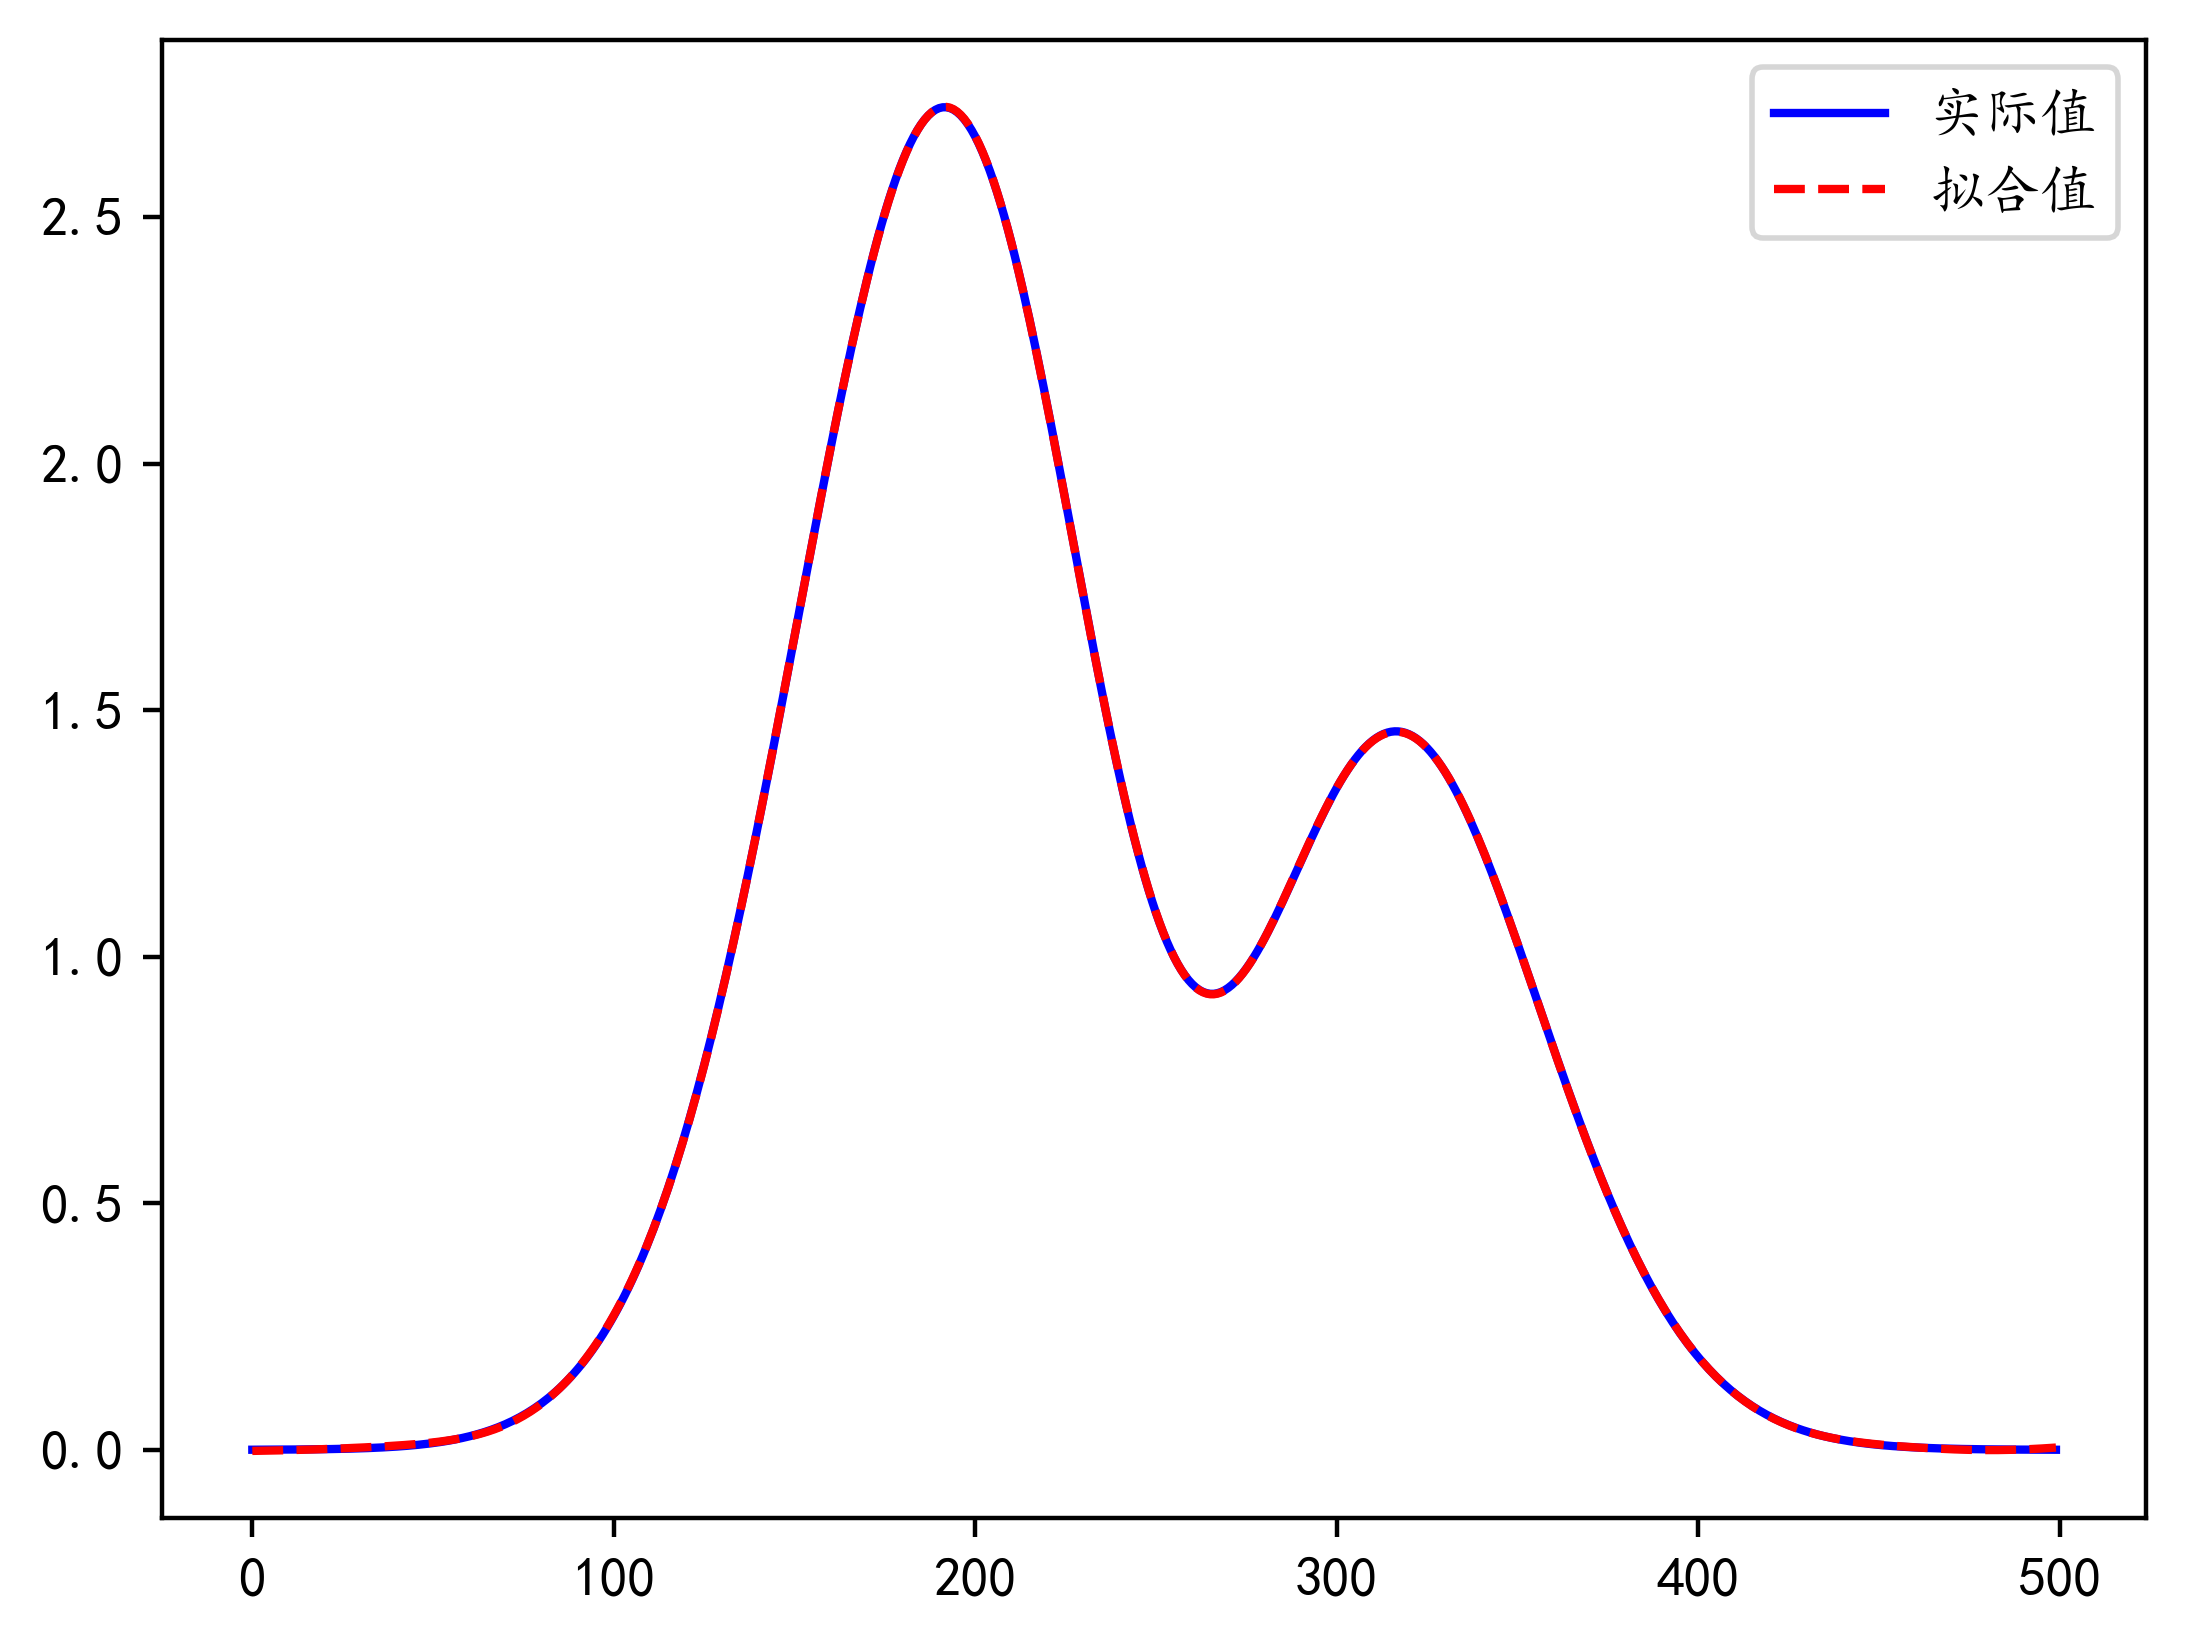

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
"""
参考：https://goodgoodstudy.blog.csdn.net/article/details/105756137
"""

def SaveImage(label,pre,path):
    label = label.view(-1).cpu().detach().numpy()
    pre = pre.view(-1).cpu().detach().numpy()
    plt.rcParams['font.sans-serif'] = 'KaiTi'
    plt.rcParams['axes.unicode_minus'] = False
    fig = plt.figure(dpi=400)
    ax = fig.add_subplot(111)
    ax.plot(label, color='blue', label="实际值")
    ax.plot(pre, color='red', linestyle='--', label='拟合值')
    ax.legend()
    fig.savefig(path, dpi=400)

class RBF(nn.Module):
    def __init__(self,centers,n_out=1):
        super(RBF, self).__init__()
        self.n_out = n_out
        self.num_centers = centers.size(0)

        self.centers = nn.Parameter(centers)
        self.beta = nn.Parameter(torch.ones(1,self.num_centers))
        self.linear = nn.Linear(self.num_centers+n_out,self.n_out)
        self.initialize_weights()

    def kernel_fun(self,batches):
        n_input = batches.size(0)
        c = self.centers.view(self.num_centers,-1).repeat(n_input,1,1)# torch.Size([500, 500, 1])
        x = batches.view(n_input,-1).unsqueeze(1).repeat(1,self.num_centers,1)# torch.Size([500, 500, 1])
        radial_val = torch.exp(-self.beta.mul((c-x).pow(2).sum(2)))
        return radial_val

    def forward(self,x):
        # 计算径向基距离函数
        radial_val = self.kernel_fun(x)
        out = self.linear(torch.cat([x,radial_val],dim=1))
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.2)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.2)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.2)
                m.bias.data.zero_()


num_centers = 500
n_out = 1
centers = torch.randn(num_centers,n_out)

model = RBF(centers,n_out=1)
optimizer = optim.Adam(model.parameters(),lr=0.1)
loss_fun = nn.MSELoss()

X_ = torch.linspace(-5,5,500).view(500,1)
Y_ = torch.mul(1.1*(1-X_+X_.pow(2).mul(2)),torch.exp(X_.pow(2).mul(-0.5)))

start = time.time()
epochs = 1000
for epoch in range(epochs):
    avg_loss = 0
    Y_pre = model(X_)
    loss = loss_fun(Y_pre,Y_)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("epoch:{}\t  loss:{:>.9}".format(epoch+1,loss.item()))
end = time.time()
print("time:",end-start)

Y_pre = model(X_)
SaveImage(Y_,Y_pre,"RBF.png")



